In [5]:
import torch, os

In [6]:
path = "alpaca-7b-wdiff/"
os.listdir(path)
split_num = 1
pth =  path + f"pytorch_model-0000{split_num}-of-00003.bin"
pth

'alpaca-7b-wdiff/pytorch_model-00001-of-00003.bin'

In [7]:
# Assume: M1 Mac chip with MPS GPU
# Load as memmap in cpu -> move to MPS GPU in float32 -> visualise in cpu
state_dict = torch.load(pth, map_location=torch.device("cpu"), mmap=True)
{key: state_dict[key].shape for key in state_dict.keys()}

{'model.embed_tokens.weight': torch.Size([32001, 4096]),
 'model.layers.0.self_attn.q_proj.weight': torch.Size([4096, 4096]),
 'model.layers.0.self_attn.k_proj.weight': torch.Size([4096, 4096]),
 'model.layers.0.self_attn.v_proj.weight': torch.Size([4096, 4096]),
 'model.layers.0.self_attn.o_proj.weight': torch.Size([4096, 4096]),
 'model.layers.0.self_attn.rotary_emb.inv_freq': torch.Size([64]),
 'model.layers.0.mlp.gate_proj.weight': torch.Size([11008, 4096]),
 'model.layers.0.mlp.down_proj.weight': torch.Size([4096, 11008]),
 'model.layers.0.mlp.up_proj.weight': torch.Size([11008, 4096]),
 'model.layers.0.input_layernorm.weight': torch.Size([4096]),
 'model.layers.0.post_attention_layernorm.weight': torch.Size([4096]),
 'model.layers.1.self_attn.q_proj.weight': torch.Size([4096, 4096]),
 'model.layers.1.self_attn.k_proj.weight': torch.Size([4096, 4096]),
 'model.layers.1.self_attn.v_proj.weight': torch.Size([4096, 4096]),
 'model.layers.1.self_attn.o_proj.weight': torch.Size([4096, 

In [8]:
def angles_in_unit_vectors_of_matrix(matrix: torch.Tensor) -> torch.Tensor:
    """Find the angles between all the unit (column) vectors of a matrix.

    Args:
        matrix (torch.Tensor): Matrix of shape (N, M)

    Returns:a
        torch.Tensor: Angles in radians of shape (M, M)
    """
    # Normalize columns to ensure they are unit vectors
    normalized_matrix = matrix / matrix.norm(dim=0)

    # Compute the dot product between all pairs of columns
    dot_products = torch.matmul(normalized_matrix.t(), normalized_matrix)

    # Ensure dot products are within [-1, 1] due to potential numerical issues
    dot_products = torch.clamp(dot_products, min=-1.0, max=1.0)

    # Compute the angles between columns using the arccosine function
    angles = torch.acos(dot_products)

    return angles

In [9]:
MPS = {'device': 'mps', 'dtype': torch.float32}
CPU = {'device': 'cpu', 'dtype': torch.float16}	

In [10]:
angles = angles_in_unit_vectors_of_matrix(
    state_dict["model.layers.0.self_attn.q_proj.weight"].to(**MPS)
)
angles

/Users/markuszhang/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  nonzero_finite_vals = torch.masked_select(


tensor([[0.0000e+00, 1.4365e+00, 1.6082e+00,  ..., 1.4867e+00, 1.3920e+00,
         1.6270e+00],
        [1.4365e+00, 0.0000e+00, 1.6597e+00,  ..., 1.5049e+00, 1.4518e+00,
         1.6579e+00],
        [1.6082e+00, 1.6597e+00, 4.8828e-04,  ..., 1.7076e+00, 1.6881e+00,
         1.5986e+00],
        ...,
        [1.4867e+00, 1.5049e+00, 1.7076e+00,  ..., 1.5441e-03, 1.5977e+00,
         1.6473e+00],
        [1.3920e+00, 1.4518e+00, 1.6881e+00,  ..., 1.5977e+00, 0.0000e+00,
         1.5853e+00],
        [1.6270e+00, 1.6579e+00, 1.5986e+00,  ..., 1.6473e+00, 1.5853e+00,
         1.4648e-03]], device='mps:0')

In [11]:
def upper_triangle(symmetric_matrix):
    """
    Extracts the upper triangle of a symmetric matrix (including the diagonal)
    and returns a flat vector without the masked zeros.

    Args:
        symmetric_matrix (torch.Tensor): The symmetric matrix from which the upper
            triangle (including the diagonal) will be extracted.

    Returns:
        torch.Tensor: A 1D tensor containing the upper triangle elements (including
            the diagonal) without the masked zeros.
    """
    # Use torch.triu to extract the upper triangle (including the diagonal)
    upper_triangle = torch.triu(symmetric_matrix)

    # Convert the upper triangle to a flat vector without masked zeros
    flat_vector = upper_triangle[upper_triangle != 0]

    return flat_vector

In [12]:
angledict = {}
for k in state_dict:
    matrix = state_dict[k].to(**MPS)
    # Vectors and empty tensors don't get LoRa'd.
    if len(matrix.shape) >= 2:
        angles = upper_triangle(angles_in_unit_vectors_of_matrix(matrix))
        angledict[k] = angles.to(**CPU)
        print(k, matrix.shape, angles.shape)

model.embed_tokens.weight torch.Size([32001, 4096]) torch.Size([8389677])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([8388727])
model.layers.0.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([8388806])
model.layers.0.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([8388796])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Size([8388760])
model.layers.0.mlp.gate_proj.weight torch.Size([11008, 4096]) torch.Size([8389237])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 11008]) torch.Size([60588486])
model.layers.0.mlp.up_proj.weight torch.Size([11008, 4096]) torch.Size([8389143])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096]) torch.Size([8388735])
model.layers.1.self_attn.k_proj.weight torch.Size([4096, 4096]) torch.Size([8388814])
model.layers.1.self_attn.v_proj.weight torch.Size([4096, 4096]) torch.Size([8388750])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096]) torch.Siz

In [13]:
# torch.save angledict
torch.save(angledict, path + f"angledict_0000{split_num}.pt")

In [2]:
# Load from disk to clear, garbage collect, and save RAM for us poor peasants
import torch

path = "alpaca-7b-wdiff/"
split_num = 1
MPS = {"device": "mps", "dtype": torch.float32}
CPU = {"device": "cpu", "dtype": torch.float16}
angledict = torch.load(path + f"angledict_0000{split_num}.pt")
angledict.keys()

dict_keys(['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.2.self_attn.q_proj.weight', 'model.layers.2.self_attn.k_proj.weight', 'model.layers.2.self_attn.v_proj.weight', 'model.layers.2.self_attn.o_proj.weight', 'model.layers.2.mlp.gate_proj.weight', 'model.layers.2.mlp.down_proj.weight', 'model.layers.2.mlp.up_proj.weight', 'model.layers.3.self_attn.q_proj.weight', 'model.layers.3.self_attn.k_proj.weight', 'model.layers.3.self_attn.v

In [8]:
dist = angledict["model.layers.0.self_attn.q_proj.weight"].to(**MPS)
dist[torch.multinomial(dist, 1000)]

# For each layer, sample 1000 from multinomial
sampled_angles = {}
for k in angledict:
	  # Discard after 2**24 samples cause random sampler breaks
		dist = angledict[k].to(**MPS)[:int(2**24)]
		print(k, dist.shape)
		sampled_angles[k] = dist[torch.multinomial(dist, 1000)].to(**CPU)
		print('-- ', sampled_angles[k].shape)

model.embed_tokens.weight torch.Size([8389677])
--  torch.Size([1000])
model.layers.0.self_attn.q_proj.weight torch.Size([8388727])
--  torch.Size([1000])
model.layers.0.self_attn.k_proj.weight torch.Size([8388806])
--  torch.Size([1000])
model.layers.0.self_attn.v_proj.weight torch.Size([8388796])
--  torch.Size([1000])
model.layers.0.self_attn.o_proj.weight torch.Size([8388760])
--  torch.Size([1000])
model.layers.0.mlp.gate_proj.weight torch.Size([8389237])
--  torch.Size([1000])
model.layers.0.mlp.down_proj.weight torch.Size([16777216])
--  torch.Size([1000])
model.layers.0.mlp.up_proj.weight torch.Size([8389143])
--  torch.Size([1000])
model.layers.1.self_attn.q_proj.weight torch.Size([8388735])
--  torch.Size([1000])
model.layers.1.self_attn.k_proj.weight torch.Size([8388814])
--  torch.Size([1000])
model.layers.1.self_attn.v_proj.weight torch.Size([8388750])
--  torch.Size([1000])
model.layers.1.self_attn.o_proj.weight torch.Size([8388817])
--  torch.Size([1000])
model.layers.1.

In [9]:
{key: sampled_angles[key].shape for key in sampled_angles.keys()}

{'model.embed_tokens.weight': torch.Size([1000]),
 'model.layers.0.self_attn.q_proj.weight': torch.Size([1000]),
 'model.layers.0.self_attn.k_proj.weight': torch.Size([1000]),
 'model.layers.0.self_attn.v_proj.weight': torch.Size([1000]),
 'model.layers.0.self_attn.o_proj.weight': torch.Size([1000]),
 'model.layers.0.mlp.gate_proj.weight': torch.Size([1000]),
 'model.layers.0.mlp.down_proj.weight': torch.Size([1000]),
 'model.layers.0.mlp.up_proj.weight': torch.Size([1000]),
 'model.layers.1.self_attn.q_proj.weight': torch.Size([1000]),
 'model.layers.1.self_attn.k_proj.weight': torch.Size([1000]),
 'model.layers.1.self_attn.v_proj.weight': torch.Size([1000]),
 'model.layers.1.self_attn.o_proj.weight': torch.Size([1000]),
 'model.layers.1.mlp.gate_proj.weight': torch.Size([1000]),
 'model.layers.1.mlp.down_proj.weight': torch.Size([1000]),
 'model.layers.1.mlp.up_proj.weight': torch.Size([1000]),
 'model.layers.2.self_attn.q_proj.weight': torch.Size([1000]),
 'model.layers.2.self_attn.

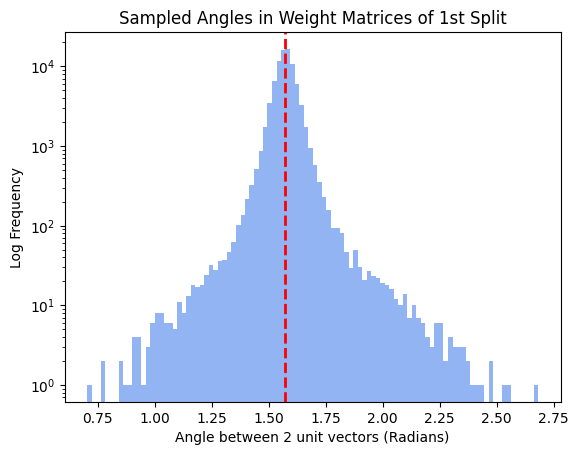

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming weights is the name of your dictionary
# Can't plot 80M points. Sample 100K from distribution. Should tend to true dist.
sampled_dist = torch.cat(list(sampled_angles.values())).numpy()

plt.hist(sampled_dist, bins=100, log=True, color="cornflowerblue", alpha=0.7)
plt.title("Sampled Angles in Weight Matrices of 1st Split")
plt.xlabel("Angle between 2 unit vectors (Radians)")
plt.ylabel("Log Frequency")

# Draw a horizontal line at y=π/2
plt.axvline(np.pi / 2, color="red", linestyle="dashed", linewidth=2, label="x=pi/2")

plt.show()